# Version 1

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,40 mins 00 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_sunnygao_fgmmh7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.651 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:05:47.846: Project: AutoML_3_20240423_180547
18:05:47.847: 5-fold cross-validation will be used.
18:05:47.848: Setting stopping tolerance adaptively based on the training frame: 0.028676966733820218
18:05:47.848: Build control seed: 1
18:05:47.849: training frame: Frame key: AutoML_3_20240423_180547_training_py_18_sid_abf4    cols: 22    rows: 1216  chunks: 1    size: 208228  checksum: -140458100710306879
18:05:47.849: validation frame: NULL
18:05:47.849: leaderboard frame: NULL
18:05:47.849: blending frame: NULL
18:05:47.849: response column: Order Item Quantity
18:05:47.849: fold column: null
18:05:47.849: weights column: null
18:05:47.851: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2

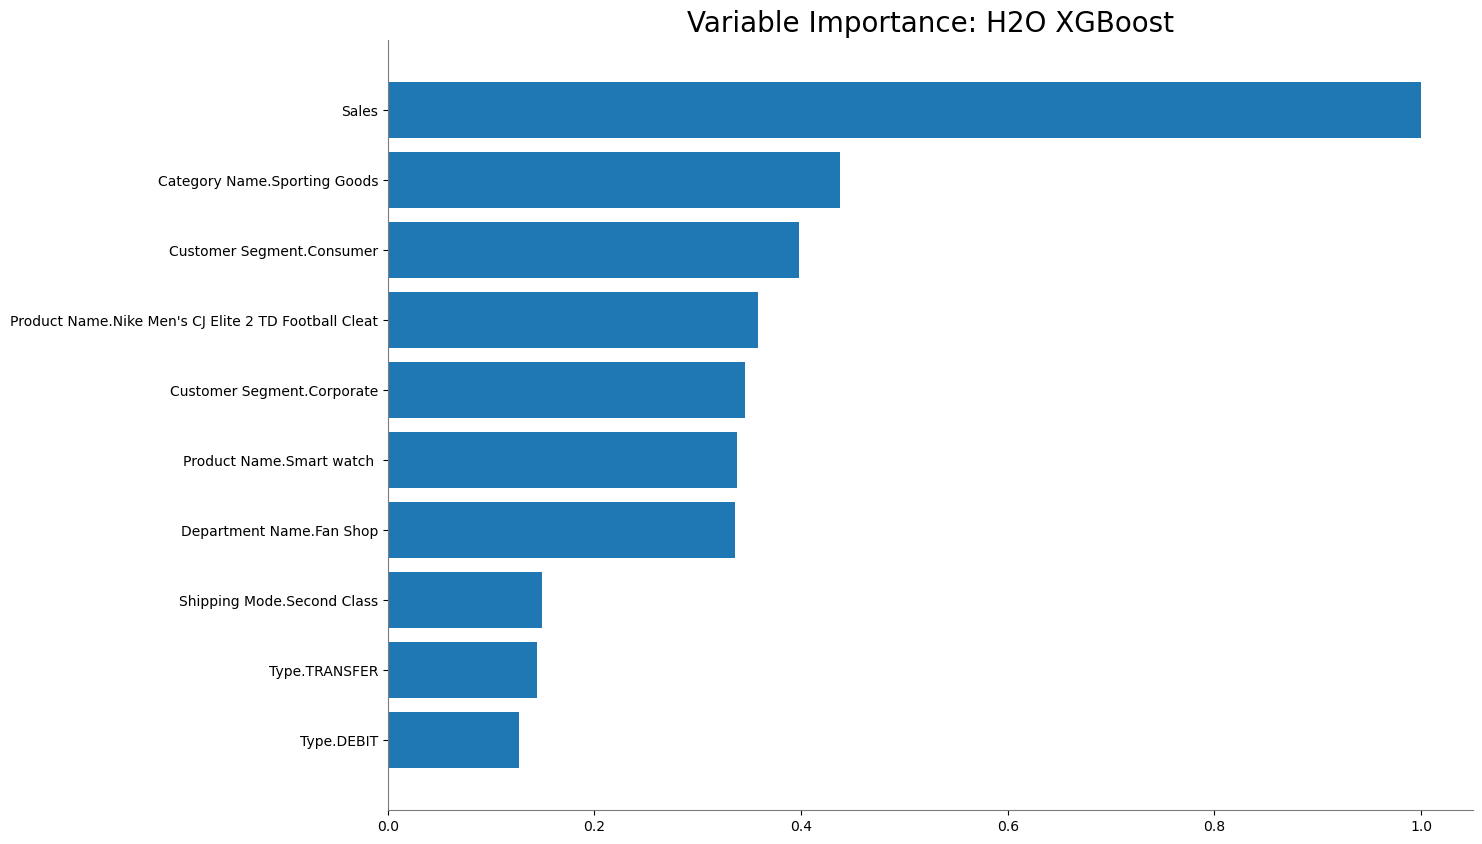

/Users/sunnygao/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Figure size 640x480 with 0 Axes>

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import mlflow
import mlflow.h2o

h2o.init()

# Custom Transformer for dropping columns
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(columns=self.columns)
        return X_copy

# Custom Transformer for adding date and time features
class DateTimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['order date (DateOrders)'] = pd.to_datetime(X_copy['order date (DateOrders)'])
        X_copy['Day of Week'] = X_copy['order date (DateOrders)'].dt.dayofweek
        X_copy['Month'] = X_copy['order date (DateOrders)'].dt.month
        X_copy['Year'] = X_copy['order date (DateOrders)'].dt.year
        X_copy['Week of Year'] = X_copy['order date (DateOrders)'].dt.isocalendar().week
        X_copy.drop(columns=['order date (DateOrders)'], inplace=True)
        return X_copy

# Custom Transformer for MLflow experiment
class MLflowExperimentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_models=12, exclude_algos=["StackedEnsemble"], seed=1):
        self.max_models = max_models
        self.exclude_algos = exclude_algos
        self.seed = seed
    
    def fit(self, df):
        # Split data
        df = df.iloc[:2000] #### For testing purpose ####

        # H2O Frame
        hf_dataset = h2o.H2OFrame(df)
        train, test = hf_dataset.split_frame(ratios=[0.6], seed=1)

        # Define the target and features
        y = "Order Item Quantity"
        X = hf_dataset.columns
        X.remove(y)

        # Start MLflow experiment
        with mlflow.start_run():
            # Configure and run H2O AutoML
            h2o_aml = H2OAutoML(max_models=12, seed=1, exclude_algos=["StackedEnsemble"], verbosity="info")
            h2o_aml.train(x=X, y=y, training_frame=train)

            # Log model
            mlflow.h2o.log_model(h2o_aml.leader, "model")

            # Logging parameters and metrics
            mlflow.log_params({
                "max_models": 12,
                "exclude_algos": "StackedEnsemble",
                "seed": 1
            })

            # Access performance metrics from the leaderboard
            perf = h2o_aml.leader.model_performance(test)
            mlflow.log_metrics({
                "rmse": perf.rmse(),
                "mae": perf.mae(),
                "r2": perf.r2()
            })

            # Variable importance plot
            h2o_aml.leader.varimp_plot()

            # Log the leaderboard
            lb = h2o_aml.leaderboard.as_data_frame()
            lb.to_csv("leaderboard.csv", index=False)
            mlflow.log_artifact("leaderboard.csv")

            # End run
            mlflow.end_run()

        return self
    
    def transform(self, X):
        # Dummy transform method
        return X

    
# Pipeline definition
data_pipeline = Pipeline([
    ('load_data', None),  # Placeholder for loading data
    ('data_cleaning', DropColumnsTransformer(columns=['Days for shipping (real)', 'Delivery Status', 'Late_delivery_risk', 
                                                      'shipping date (DateOrders)', 'Benefit per order', 'Sales per customer', 'Category Id',
                                                      'Order Profit Per Order', 'Order Item Discount', 'Order Item Total', 'Order Status', 
                                                      'Customer Email', 'Customer Password', 'Latitude', 'Longitude', 'Product Description', 'Product Image',
                                                      'Customer Fname', 'Customer Id', 'Customer Lname', 'Department Id',
                                                      'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Id',
                                                      'Product Card Id', 'Product Category Id', 'Order Id', 'Customer Street',
                                                      'Customer Zipcode', 'Order Zipcode', 'Order Item Product Price',
                                                      'Product Price', 'Order Item Profit Ratio', 'Product Status'])),
    ('date_time_features', DateTimeFeaturesTransformer()),
    ('mlflow_experiment', MLflowExperimentTransformer(max_models=12, exclude_algos=["StackedEnsemble"], seed=1))
])

# Load data
supplyChain = pd.read_csv("DataCoSupplyChainDataset.csv", encoding='ISO-8859-1')

# Execute the pipeline
processed_data = data_pipeline.fit_transform(supplyChain)

# Version 2

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_411"; Java(TM) SE Runtime Environment (build 1.8.0_411-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from /Users/sunnygao/anaconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/rn/l2tch0d14t10b6sh58c23xfm0000gn/T/tmpha0mxcux
  JVM stdout: /var/folders/rn/l2tch0d14t10b6sh58c23xfm0000gn/T/tmpha0mxcux/h2o_sunnygao_started_from_python.out
  JVM stderr: /var/folders/rn/l2tch0d14t10b6sh58c23xfm0000gn/T/tmpha0mxcux/h2o_sunnygao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_sunnygao_ek5nha
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:27:01.308: Project: AutoML_1_20240424_152701
15:27:01.320: 5-fold cross-validation will be used.
15:27:01.323: Setting stopping tolerance adaptively based on the training frame: 0.028676966733820218
15:27:01.323: Build control seed: 1
15:27:01.325: training frame: Frame key: AutoML_1_20240424_152701_training_py_2_sid_a457    cols: 22    rows: 1216  chunks: 1    size: 208228  checksum: -140458100710306879
15:27:01.326: validation frame: NULL
15:27:01.326: leaderboard frame: NULL
15:27:01.326: blending frame: NULL
15:27:01.326: response column: Order Item Quantity
15:27:01.326: fold column: null
15:27:01.326: weights column: null
15:27:01.393: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g

/Users/sunnygao/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model saved to: /Users/sunnygao/Desktop/INSY695-078/final_project/models/XGBoost_2_AutoML_1_20240424_152701


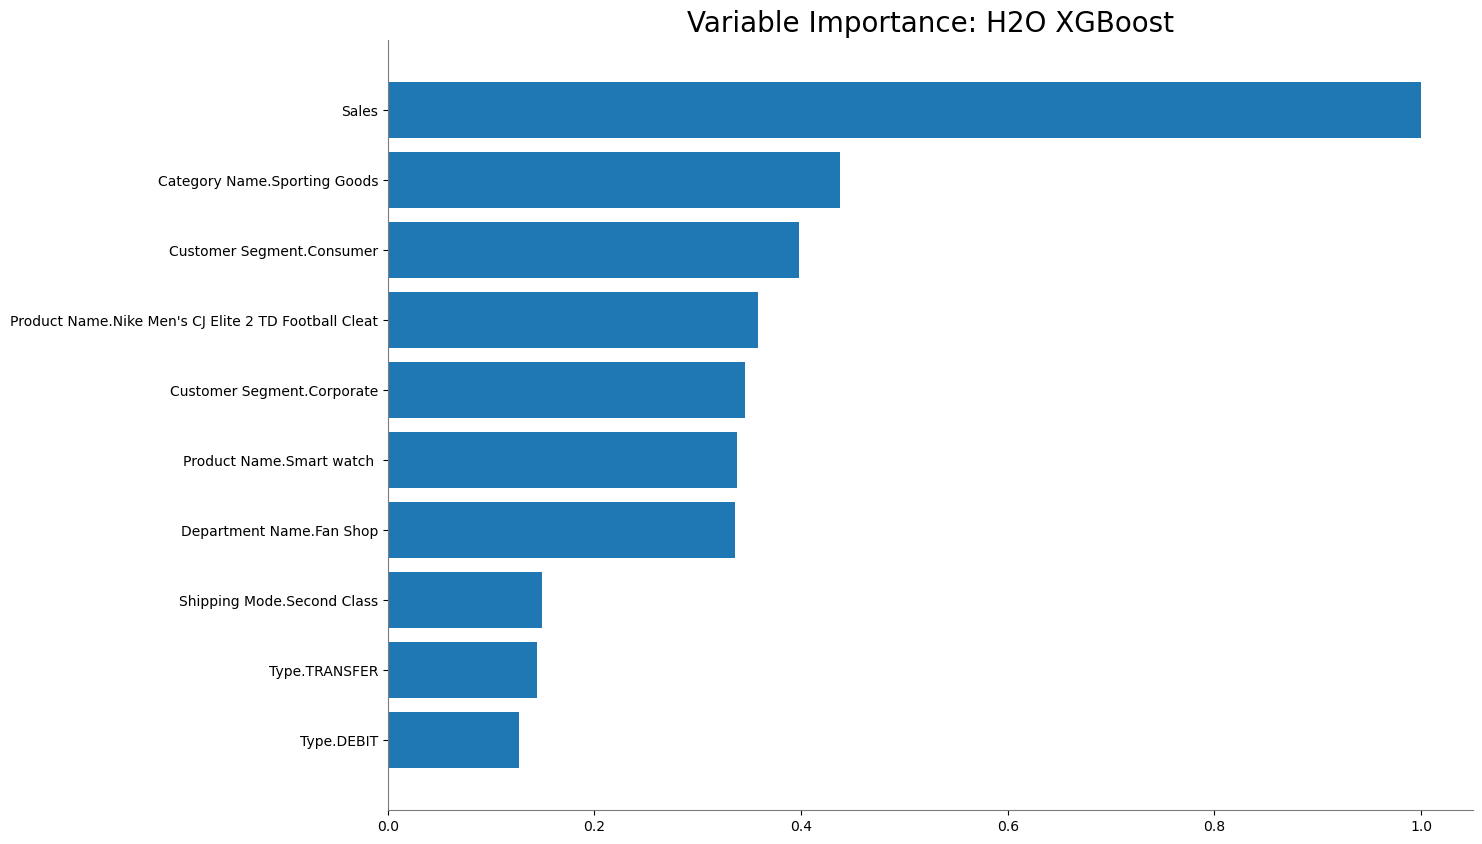

Saving figure varimp_plot


/Users/sunnygao/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Figure size 640x480 with 0 Axes>

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import mlflow
import mlflow.h2o
from pathlib import Path
import matplotlib.pyplot as plt

# Function definitions for data loading, saving, and plotting
DATA_PATH = Path() / "../final_project/data"
DATA_PATH.mkdir(parents=True, exist_ok=True)

def load_csv(filename, data_path=DATA_PATH, encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path, encoding=encoding)

def save_csv(data, filename, data_path=DATA_PATH, encoding='ISO-8859-1'):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False, encoding=encoding)

PLOT_PATH = Path() / "../final_project/plot"
PLOT_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)

RESULT_PATH = Path() / "../final_project/result"
RESULT_PATH.mkdir(parents=True, exist_ok=True)

def save_result(data, filename, data_path=RESULT_PATH):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False, encoding='utf-8-sig')

MODEL_PATH = Path() / "../final_project/models"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

def save_h2o_model(model, filename, model_path=MODEL_PATH):
    full_path = model_path / filename
    full_path.parent.mkdir(parents=True, exist_ok=True)
    saved_model_path = h2o.save_model(model=model, path=str(full_path.parent), force=True)
    print(f"Model saved to: {saved_model_path}")
    return saved_model_path

# Custom Transformer for dropping columns
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(columns=self.columns)
        return X_copy

# Custom Transformer for adding date and time features
class DateTimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['order date (DateOrders)'] = pd.to_datetime(X_copy['order date (DateOrders)'])
        X_copy['Day of Week'] = X_copy['order date (DateOrders)'].dt.dayofweek
        X_copy['Month'] = X_copy['order date (DateOrders)'].dt.month
        X_copy['Year'] = X_copy['order date (DateOrders)'].dt.year
        X_copy['Week of Year'] = X_copy['order date (DateOrders)'].dt.isocalendar().week
        X_copy.drop(columns=['order date (DateOrders)'], inplace=True)
        return X_copy

# Custom Transformer for MLflow experiment
class MLflowExperimentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_models=12, exclude_algos=["StackedEnsemble"], seed=1):
        self.max_models = max_models
        self.exclude_algos = exclude_algos
        self.seed = seed
    
    def fit(self, df):
        # Initialize H2O
        h2o.init()

        # H2O Frame
        hf_dataset = h2o.H2OFrame(df[:2000])
        train, test = hf_dataset.split_frame(ratios=[0.6], seed=1)

        # Define the target and features
        y = "Order Item Quantity"
        X = hf_dataset.columns
        X.remove(y)

        # Start MLflow experiment
        with mlflow.start_run():
            # Configure and run H2O AutoML
            h2o_aml = H2OAutoML(max_models=self.max_models, seed=self.seed, exclude_algos=self.exclude_algos, verbosity="info")
            h2o_aml.train(x=X, y=y, training_frame=train)

            # Log model
            mlflow.h2o.log_model(h2o_aml.leader, "model")

            # Now, save the model using the new function
            model_filename = "best_model_demand_forcasting"
            save_h2o_model(h2o_aml.leader, model_filename)

            # Logging parameters and metrics
            mlflow.log_params({
                "max_models": self.max_models,
                "exclude_algos": ",".join(self.exclude_algos),
                "seed": self.seed
            })

            # Access performance metrics from the leaderboard
            perf = h2o_aml.leader.model_performance(test)
            mlflow.log_metrics({
                "rmse": perf.rmse(),
                "mae": perf.mae(),
                "r2": perf.r2()
            })

            # Variable importance plot
            h2o_aml.leader.varimp_plot()
            save_fig("varimp_plot")

            # Log the leaderboard
            lb = h2o_aml.leaderboard.as_data_frame()
            save_result(lb, "leaderboard.csv")
            mlflow.log_artifact("leaderboard.csv")

            # End run
            mlflow.end_run()

        return self
    
    def transform(self, X):
        # Dummy transform method
        return X

# Pipeline definition
data_pipeline = Pipeline([
    ('load_data', None),  # Placeholder for loading data
    ('data_cleaning', DropColumnsTransformer(columns=['Days for shipping (real)', 'Delivery Status', 'Late_delivery_risk', 
                                                      'shipping date (DateOrders)', 'Benefit per order', 'Sales per customer', 'Category Id',
                                                      'Order Profit Per Order', 'Order Item Discount', 'Order Item Total', 'Order Status', 
                                                      'Customer Email', 'Customer Password', 'Latitude', 'Longitude', 'Product Description', 'Product Image',
                                                      'Customer Fname', 'Customer Id', 'Customer Lname', 'Department Id',
                                                      'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Id',
                                                      'Product Card Id', 'Product Category Id', 'Order Id', 'Customer Street',
                                                      'Customer Zipcode', 'Order Zipcode', 'Order Item Product Price',
                                                      'Product Price', 'Order Item Profit Ratio', 'Product Status'])),
    ('date_time_features', DateTimeFeaturesTransformer()),
    ('mlflow_experiment', MLflowExperimentTransformer(max_models=12, exclude_algos=["StackedEnsemble"], seed=1))
])

# Load data
supplyChain = load_csv("DataCoSupplyChainDataset.csv")

# Execute the pipeline
processed_data = data_pipeline.fit_transform(supplyChain)
